In [1]:
%load_ext autoreload
%autoreload 2
import sys
import os
sys.path.insert(1, '../../yukun_disentanglement_lib/')
sys.path.insert(0, '../source_tf/utils')
sys.path.insert(0, '../source_tf/models')
from keras import metrics
import tensorflow_hub as hub
import tensorflow as tf
import yukun_disentanglement_lib
from yukun_disentanglement_lib.data.ground_truth import celeba, celebaHR
from data_helpers import DataProvider
from simgan_models import simgan_decoder, simgan_decoder_hr, simgan_discriminator, simgan_encoder
from dsvae_model_large_HR import DSVAELHR, loss_function
from dsvae_model_large_HR import DSVAELHR, loss_function
import numpy as np
import time, math
from misc import merge
import argparse
import wandb
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np
import torch

Using TensorFlow backend.


In [2]:
log = False
if log:
    wandb.init(project="pytorch_dsvae_hr", name="celeba_dsvae_10k_large")

# Load the data

In [3]:
parser = argparse.ArgumentParser()
parser.add_argument("--z_dim", help="z dimension", default=85, type=int)
parser.add_argument("--device", help="gpu id", default=-1, type=int)
parser.add_argument("--nb_epochs", help="number of epochs", default=500, type=int)
parser.add_argument("--start_epoch", help="epoch to start training from (requires checkpoints)", default=0, type=int)
parser.add_argument("--save_interval", help="epochs to save model", default=10, type=int)
parser.add_argument("--run_seed", help="run seed of TCVAE", default=100, type=int)
parser.add_argument("--lr", help="learning rate", default=.0001, type=float)
parser.add_argument("--batch_size", help="batch size", default=100, type=int)
args = parser.parse_args([])

if log:
    wandb.config.update(args)

device = args.device
print("z_dim: {}".format(args.z_dim))
print("GPU: {}".format(device))
print("start_epoch: {}".format(args.start_epoch))
print("save_interval: {}".format(args.save_interval))

#path to classifier
classifier_url = '../../tcvae_models/celeba10/train_output/d_15_b_15_{}/tfhub/'.format(0)
# classifier_url = '../../tcvae_models/celeba/train_output/100k/d_15_b_15_{}/tfhub/'.format(args.run_seed)
print("Classifier URL")
print(classifier_url)
classifier = hub.Module(classifier_url)
num_samples=10000
dta = celeba.CelebA(celeba_path="../../yukun_disentanglement_lib/img_align_celeba", num_samples=num_samples)
dtahr = celebaHR.CelebAHR(celeba_path="../../yukun_disentanglement_lib/img_align_celeba", num_samples=num_samples, res=128)

z_dim: 85
GPU: -1
start_epoch: 0
save_interval: 10
Classifier URL
../../tcvae_models/celeba10/train_output/d_15_b_15_0/tfhub/
10000
finish reading face images
(10000, 64, 64, 3)
10000
finish reading face images
(10000, 128, 128, 3)


In [4]:
# celeba from yukun_dis_lib
load = True
save = True
num_y_samples = 10
tf.set_random_seed(1)
if not load:
    raw_pics = np.float32(np.empty((num_samples, num_y_samples, 64, 64,3)))
    with hub.eval_function_for_module(classifier_url) as f:
        for j in range(num_y_samples):
            raw_pic = []
            for i in range(10):
                real_pics = np.float32(dta.images[i*int(num_samples/10):(i+1)*int(num_samples/10)])
                raw_pic.append(f(dict(images=real_pics), signature="reconstructions", as_dict=True)["images"]) 
            raw_pics[:,j] = np.float32(np.concatenate(raw_pic,axis=0))
    inputs = np.float32(dta.images)
    inputshr = np.float32(dtahr.images)
    targets = np.float32(raw_pics)
    if save:
        np.save('data_hr128/inputs_10k_sample', inputs)
        np.save('data_hr128/inputs_10k_sample_hr', inputshr)
        np.save('data_hr128/targets_10k_sample', targets)     
else:  
    inputs = np.load('data_hr128/inputs_10k_sample.npy')
    inputshr = np.load('data_hr128/inputs_10k_sample_hr.npy')
    targets = np.load('data_hr128/targets_10k_sample.npy')

In [5]:
torch_inputs = torch.from_numpy(inputs).permute(0,3,1,2)
torch_inputs_hr = torch.from_numpy(inputshr).permute(0,3,1,2)
torch_targets = torch.from_numpy(targets).permute(0,1,4,2,3)

In [6]:
from pytorch_data_utils import DSVAE_DATA_HR
torch_dataset = DSVAE_DATA_HR(torch_inputs, torch_inputs_hr, torch_targets)
torch_data_loader = torch.utils.data.DataLoader(torch_dataset, batch_size=args.batch_size, shuffle=True)

In [7]:
def plot_pytorch_images(images, num_images=5, title=""):
    if images.is_cuda:
        images = images.detach().cpu()
    else:
        images = images.detach()
    images = images.permute(0,2,3,1)
    img = np.expand_dims(images,0)
    img = merge(img[0],[1,num_images])
    fig = plt.figure(figsize=(8*max(1, num_images-2),8))
    plt.imshow(img)
    plt.gray()
    plt.title(title)
    plt.show()
    return fig

In [8]:
load_model = True
if load_model:
    dsvae = torch.load("saved_models/dsvae_pytorch_4000_large_hr")
else:
    if args.device != -1:
        dsvae = DSVAELHR(z_dim=85, device=args.device)
        dsvae.to(device)
    else:
        dsvae = DSVAELHR(z_dim=85, device=None)
    optimizer = torch.optim.Adam(params=dsvae.parameters(), lr=args.lr)

In [9]:
dsvae = dsvae.cpu()

In [10]:
dsvae.eval()
x, x_hr, y_all = torch_dataset[:32]
x_hr_hats = []
for i in range(10):
    x_hr_hat, _,_ = dsvae(x, y_all[:,i])
    x_hr_hats.append(x_hr_hat)

In [35]:
y_images[0:1].shape

torch.Size([1, 3, 64, 64])

In [39]:
torch.distributions.Normal(0,1).sample((1,3,64,64)).shape

torch.Size([1, 3, 64, 64])

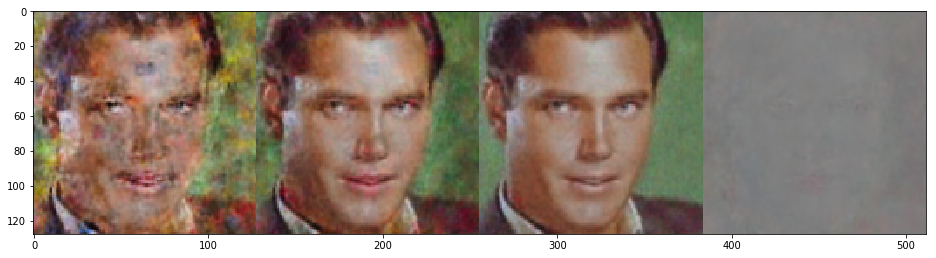

In [49]:
x_images = torch_dataset[0:4:2][0]
x_hr_images = torch_dataset[0:4:2][1]
y_images = torch_dataset[0:4:2][2][:,0]

x_hr_hat, z_mu, z_var = dsvae(x_images, y_images)
# plot_pytorch_images(x_hr_images, num_images=2)
# plot_pytorch_images(torch.sigmoid(y_images), num_images=2)
# plot_pytorch_images(x_hr_hat, num_images=2);

x_hr_hat_new = dsvae.decode(y_images[0:1], z_mu[1:2])
x_hr_hat_new_zeros = dsvae.decode(torch.distributions.Normal(0,1).sample((1,3,64,64)), z_mu[1:2])
x_hr_residual = torch.sigmoid(x_hr_hat_new[0] - x_hr_hat[1])
plot_pytorch_images(torch.cat((x_hr_hat_new_zeros, x_hr_hat_new, x_hr_hat[1].unsqueeze(0), x_hr_residual.unsqueeze(0))), num_images=4);

In [52]:
torch.distributions.Normal(0,1).sample(y_images.shape).shape

torch.Size([2, 3, 64, 64])

In [198]:
means.shape

(64, 15)

In [267]:
import numbers
import os
from yukun_disentanglement_lib.data.ground_truth import named_data
from yukun_disentanglement_lib.utils import results
from yukun_disentanglement_lib.visualize import visualize_util
from yukun_disentanglement_lib.visualize.visualize_irs import vis_all_interventional_effects
import numpy as np
from scipy import stats
from six.moves import range
from tensorflow import gfile
import gin.tf
from yukun_disentanglement_lib.visualize.visualize_model import latent_traversal_1d_multi_dim, sigmoid, tanh, latent_traversal_1d_multi_dim_dsvae, latent_traversal_1d_multi_dim_dsvae_new

output_dir = 'visualize_output_sample'
print(output_dir)
dlib_model_path = '/hdd/dsvae/tcvae_models/celeba10/train_output/d_15_b_15_{}/'.format(0)
model_dir = os.path.join(dlib_model_path, '')
overwrite=True
num_animations=5
num_frames=32
fps=10
num_points_irs=10000
# Create the output directory if necessary.
if tf.gfile.IsDirectory(output_dir):
    if overwrite:
        tf.gfile.DeleteRecursively(output_dir)
    else:
        raise ValueError("Directory already exists and overwrite is False.")

gin_config_file = os.path.join(model_dir, "results", "gin", "train.gin")
print(gin_config_file)
gin_dict = results.gin_dict(gin_config_file)

num_pics = 32
module_path = os.path.join(model_dir, "tfhub")
dsvae.eval()
with hub.eval_function_for_module(module_path) as f:
    # Save reconstructions.
    random_state = np.random.RandomState(2)
    real_pics_hr = dtahr.sample_observations(num_pics, random_state)
    random_state = np.random.RandomState(2)
    real_pics = dta.sample_observations(num_pics, random_state)
    raw_pics = f(dict(images=real_pics), signature="reconstructions", as_dict=True)["images"]
    pics = sigmoid(raw_pics)
    pics = np.pad(pics, ((0, 0), (32,32), (32,32), (0, 0)), 'constant', constant_values=0)

    torch_real_pics = torch.from_numpy(real_pics).permute(0,3,1,2).float()
    torch_raw_pics = torch.from_numpy(raw_pics).permute(0,3,1,2).float()
    
    x_hr_hat, _,_ = dsvae(torch_real_pics, torch_raw_pics)
    x_hr_hat_numpy = x_hr_hat.detach().permute(0,2,3,1).numpy()
        
    paired_pics = np.concatenate((real_pics_hr, pics), axis=2)
    paired_pics = [paired_pics[i, :, :, :] for i in range(paired_pics.shape[0])]
    results_dir = os.path.join(output_dir, "reconstructions")
    if not gfile.IsDirectory(results_dir):
        gfile.MakeDirs(results_dir)
    visualize_util.grid_save_images(
        paired_pics, os.path.join(results_dir, "reconstructions.jpg"))
    paired_pics = np.concatenate((real_pics_hr, pics, x_hr_hat_numpy), axis=2)
    paired_pics = [paired_pics[i, :, :, :] for i in range(paired_pics.shape[0])]
    results_dir = os.path.join(output_dir, "reconstructions")
    if not gfile.IsDirectory(results_dir):
        gfile.MakeDirs(results_dir)
    visualize_util.grid_save_images(
        paired_pics, os.path.join(results_dir, "reconstructions_dsvae.jpg"))
    print("finished reconstructions")
    
    # Save samples
    def _decoder(latent_vectors):
        return f(
          dict(latent_vectors=latent_vectors),
          signature="decoder",
          as_dict=True)["images"]
    num_latent = int(gin_dict["encoder.num_latent"])
    num_pics = 64
    random_codes = random_state.normal(0, 1, [num_pics, num_latent])
    pics = sigmoid(_decoder(random_codes))
    results_dir = os.path.join(output_dir, "sampled")
    if not gfile.IsDirectory(results_dir):
        gfile.MakeDirs(results_dir)
    visualize_util.grid_save_images(pics,
                                    os.path.join(results_dir, "samples.jpg"))
    print("finished samples")
    # Save latent traversals.
    input_images = dta.sample_observations(num_pics, random_state)
    result = f(dict(images=input_images), signature="gaussian_encoder", as_dict=True)
    means = result["mean"]
    logvars = result["logvar"]
    raw_pics = _decoder(means)
    torch_real_pics = torch.from_numpy(input_images).permute(0,3,1,2)
    torch_raw_pics = torch.from_numpy(raw_pics).permute(0,3,1,2)
    x_hr_hat, z_mu, z_var = dsvae(torch_real_pics, torch_raw_pics)
    results_dir = os.path.join(output_dir, "traversals")
    if not gfile.IsDirectory(results_dir):
        gfile.MakeDirs(results_dir)
    for i in range(10):
#         dsvae_pics = latent_traversal_1d_multi_dim_dsvae(dsvae, z_mu[i, :], _decoder, means[i, :])
        dsvae_pics_new = latent_traversal_1d_multi_dim_dsvae_new(dsvae, torch_real_pics[i], _decoder, means[i, :])
        pics = sigmoid(latent_traversal_1d_multi_dim(_decoder, means[i, :], None)) 
        
        file_name = os.path.join(results_dir, "traversals{}.jpg".format(i))
        visualize_util.grid_save_images([pics], file_name)
        
#         file_name = os.path.join(results_dir, "traversals_dsvae{}.jpg".format(i))
#         visualize_util.grid_save_images([dsvae_pics], file_name)
        file_name = os.path.join(results_dir, "traversals_dsvae_new{}.jpg".format(i))
        visualize_util.grid_save_images([dsvae_pics_new], file_name)
    print("finished traversals")
        
#     # Save the latent traversal animations.
#     results_dir = os.path.join(output_dir, "animated_traversals")
#     if not gfile.IsDirectory(results_dir):
#         gfile.MakeDirs(results_dir)
#     # Save latent traversal animations as a grid
#     results_dir_grid = os.path.join(output_dir, "traversals_grid")
#     if not gfile.IsDirectory(results_dir_grid):
#         gfile.MakeDirs(results_dir_grid)
#     # Cycle through quantiles of a standard Gaussian.
#     for i, base_code in enumerate(means[:num_animations]):
#         images = []
#         y_traversal_images = []
#         #print(base_code.shape) #base_code shape is (8, )
#         for j in range(base_code.shape[0]):
#             code = np.repeat(np.expand_dims(base_code, 0), num_frames, axis=0) #Repeat c for num_frames
#             code[:, j] = visualize_util.cycle_gaussian(base_code[j], num_frames) #Get traversal values for 1 dim
#             y_traversal = _decoder(code) #y_traversal[0] corresponds to the orginal image
#             images.append(np.array(sigmoid(_decoder(code))))
#             feed_dict = {tdw_img: input_images[:batchsize], latent_noise_input_: latent_noise_batch, E_enc: y_traversal}
#             # Get z_encoder mean
#             mu, sig = sess.run([z_mu, z_sigma],feed_dict = feed_dict)
#             noise_single = mu[0]# + sig[0]*np.random.randn(mu.shape[1])
#             noise = np.repeat(np.expand_dims(noise_single, 0), num_frames, axis=0)
# #            noise = np.repeat(np.expand_dims(np.zeros(2), 0), num_frames, axis=0)
#             feed_dict = {tdw_img: x, latent_noise_input_: noise, E_enc: y_traversal}
#             sdata,  = sess.run([G_dec_sampler],feed_dict = feed_dict)
#             y_traversal_images.append(sdata)
#             inds = np.arange(0, 32, 4)
#             num_images = len(inds)
#             y_xbar = np.concatenate((images[j][inds], y_traversal_images[j][inds]))
#             img = merge(y_xbar, [2, num_images])
#             plt.figure(figsize=(16,16))
#             plt.imshow(img)
#             plt.gray()
#             plt.axis('off')
#             plt.savefig(os.path.join(results_dir_grid, "std_gaussian_cycle_latent_%d_sample_%d.jpg" % (j, i)))
#             plt.show()
#         filename = os.path.join(results_dir, "std_gaussian_cycle%d.gif" % i)
#         visualize_util.save_animation(np.array(images), filename, fps)
#         filename = os.path.join(results_dir, "twovae_zmean_repeat_std_gaussian_cycle%d.gif" % i)
#         visualize_util.save_animation(y_traversal_images, filename, fps)

visualize_output_sample
/hdd/dsvae/tcvae_models/celeba10/train_output/d_15_b_15_0/results/gin/train.gin
finished reconstructions
finished samples
finished traversals


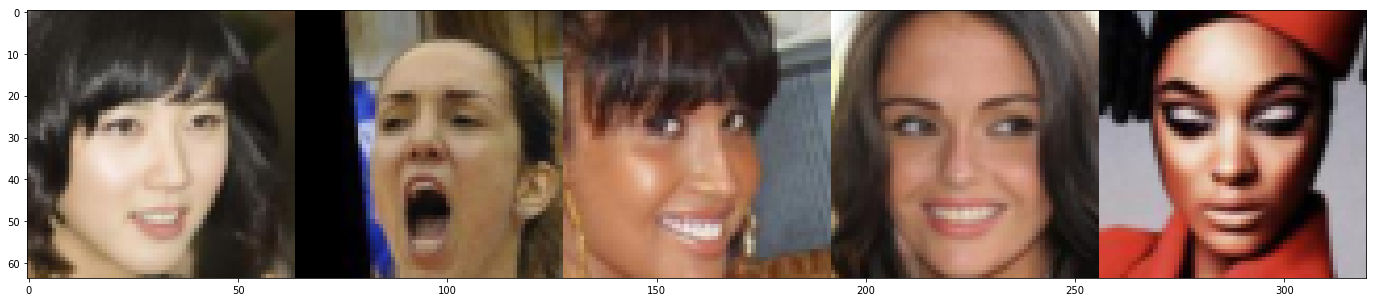

In [255]:
plot_pytorch_images(torch_real_pics[:5]);

In [261]:
torch_real_pics[0].shape

torch.Size([3, 64, 64])

In [251]:
z_mu[0,:].unsqueeze(0).repeat(11,1).shape

torch.Size([11, 85])

In [246]:
torch.cat(3*[z_mu[0,:].]).shape

torch.Size([255])

In [232]:
z_mu.shape

torch.Size([64, 85])

In [235]:
means[0,:].shape

(15,)

In [151]:
print(torch_dataset[:32][0].shape)
print(torch_dataset[:32][2][:,0].shape)

torch.Size([32, 3, 64, 64])
torch.Size([32, 3, 64, 64])


torch.Size([32, 3, 128, 128])


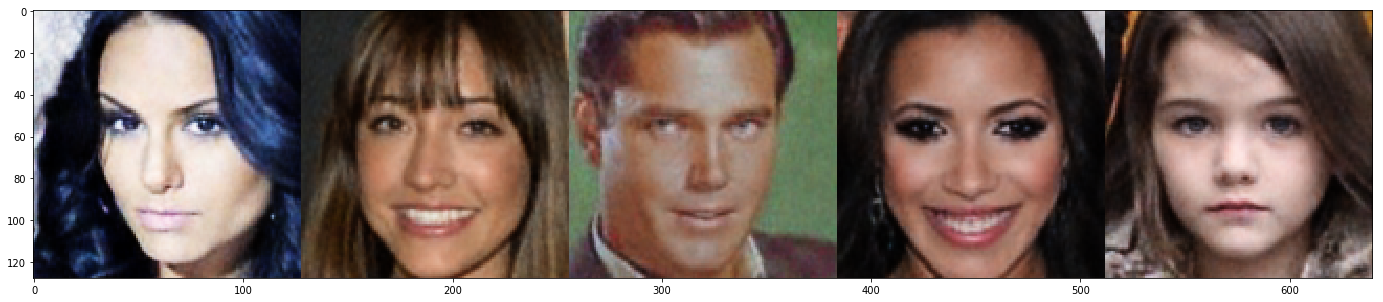

In [152]:
x_hr_hat, _,_ = dsvae(torch_dataset[:32][0],torch_dataset[:32][2][:,0])
print(x_hr_hat.shape)
plot_pytorch_images(x_hr_hat[:5]);

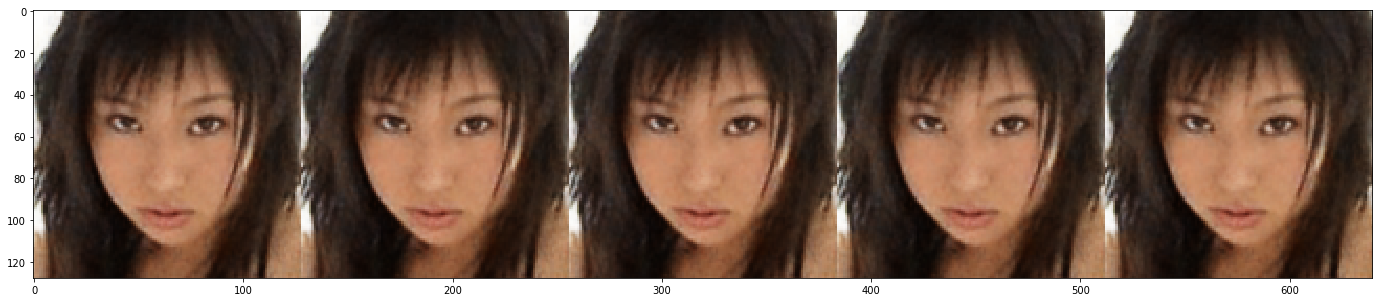

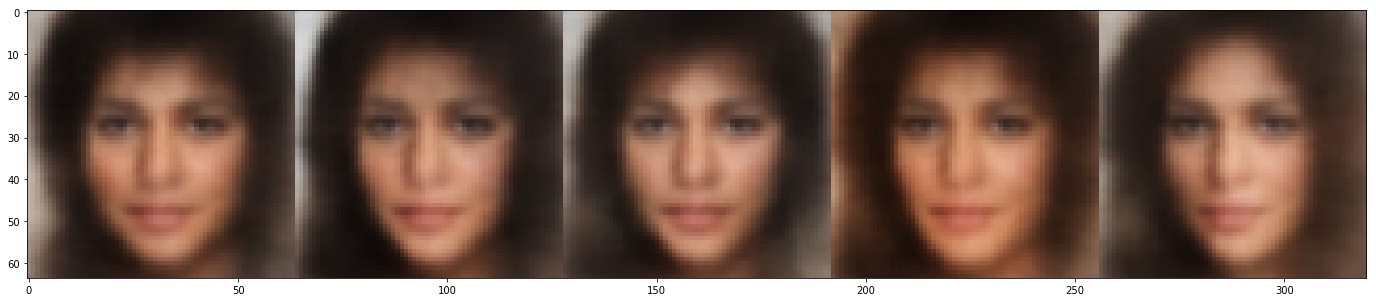

In [79]:
plot_pytorch_images(torch.cat([x_hr_hats[i][22:23] for i in range(5)]))
plot_pytorch_images(torch.sigmoid(torch.cat([y_all[22:23,i] for i in range(5)])));
# plot_pytorch_images(x_hr[:1])
# plot_pytorch_images(torch.sigmoid(y_all[:1,i]))
# plot_pytorch_images(x[:1])

# Do traversals

In [ ]:
import numbers
import os
from yukun_disentanglement_lib.data.ground_truth import named_data
from yukun_disentanglement_lib.utils import results
from yukun_disentanglement_lib.visualize import visualize_util
from yukun_disentanglement_lib.visualize.visualize_irs import vis_all_interventional_effects
import numpy as np
from scipy import stats
from six.moves import range
from tensorflow import gfile
import gin.tf
from yukun_disentanglement_lib.visualize.visualize_model import latent_traversal_1d_multi_dim, sigmoid, tanh

dataname = sys.argv[1]
output_dir = 'visualize_output_sample'
print(output_dir)
dlib_model_path = '/hdd/dsvae/tcvae_models/celeba10/train_output/d_15_b_15_{}/'.format(0)
model_dir = os.path.join(dlib_model_path, '')
overwrite=True
num_animations=5
num_frames=32
fps=10
num_points_irs=10000
random_state = np.random.RandomState(2)
# Create the output directory if necessary.
if tf.gfile.IsDirectory(output_dir):
    if overwrite:
        tf.gfile.DeleteRecursively(output_dir)
    else:
        raise ValueError("Directory already exists and overwrite is False.")

gin_config_file = os.path.join(model_dir, "results", "gin", "train.gin")
print(gin_config_file)
gin_dict = results.gin_dict(gin_config_file)
dataname = gin_dict["dataset.name"]
# Automatically infer the activation function from gin config.
activation_str = gin_dict["reconstruction_loss.activation"]
if activation_str == "'logits'":
    activation = sigmoid
elif activation_str == "'tanh'":
    activation = tanh
else:
    raise ValueError(
        "Activation function  could not be infered from gin config.")

dataset = dta
    
num_pics = 32
module_path = os.path.join(model_dir, "tfhub")
with hub.eval_function_for_module(module_path) as f:
# Save reconstructions.
    real_pics = dataset.sample_observations(num_pics, random_state)
    raw_pics = f(dict(images=real_pics), signature="reconstructions", as_dict=True)["images"]
    pics = activation(raw_pics)
    
#     latent_noise_batch = np.random.randn(batchsize, latent_noise_dim).astype(np.float32)
    feed_dict = {tdw_img: real_pics, latent_noise_input_: latent_noise_batch, E_enc: raw_pics}
    xbar,  = sess.run([G_dec], feed_dict = feed_dict)
    
    paired_pics = np.concatenate((real_pics, pics), axis=2)
    paired_pics = [paired_pics[i, :, :, :] for i in range(paired_pics.shape[0])]
    results_dir = os.path.join(output_dir, "reconstructions")
    if not gfile.IsDirectory(results_dir):
        gfile.MakeDirs(results_dir)
    visualize_util.grid_save_images(
        paired_pics, os.path.join(results_dir, "reconstructions.jpg"))
    paired_pics = np.concatenate((real_pics, pics, xbar), axis=2)
    paired_pics = [paired_pics[i, :, :, :] for i in range(paired_pics.shape[0])]
    results_dir = os.path.join(output_dir, "reconstructions")
    if not gfile.IsDirectory(results_dir):
        gfile.MakeDirs(results_dir)
    visualize_util.grid_save_images(
        paired_pics, os.path.join(results_dir, "reconstructions_dsvae.jpg"))
    # Save samples.
    def _decoder(latent_vectors):
        return f(
          dict(latent_vectors=latent_vectors),
          signature="decoder",
          as_dict=True)["images"]
    num_latent = int(gin_dict["encoder.num_latent"])
    num_pics = 64
    random_codes = random_state.normal(0, 1, [num_pics, num_latent])
    pics = activation(_decoder(random_codes))
    results_dir = os.path.join(output_dir, "sampled")
    if not gfile.IsDirectory(results_dir):
        gfile.MakeDirs(results_dir)
    visualize_util.grid_save_images(pics,
                                    os.path.join(results_dir, "samples.jpg"))
    # Save latent traversals.
    input_images = dataset.sample_observations(num_pics, random_state)
    result = f(
        dict(images=input_images),
        signature="gaussian_encoder",
        as_dict=True)
    means = result["mean"]
    logvars = result["logvar"]
    results_dir = os.path.join(output_dir, "traversals")
    if not gfile.IsDirectory(results_dir):
        gfile.MakeDirs(results_dir)
    for i in range(means.shape[1]):
        pics = activation(
          latent_traversal_1d_multi_dim(_decoder, means[i, :], None)) 
        file_name = os.path.join(results_dir, "traversals{}.jpg".format(i))
        visualize_util.grid_save_images([pics], file_name)
    # Save the latent traversal animations.
    results_dir = os.path.join(output_dir, "animated_traversals")
    if not gfile.IsDirectory(results_dir):
        gfile.MakeDirs(results_dir)
    # Save latent traversal animations as a grid
    results_dir_grid = os.path.join(output_dir, "traversals_grid")
    if not gfile.IsDirectory(results_dir_grid):
        gfile.MakeDirs(results_dir_grid)
    # Cycle through quantiles of a standard Gaussian.
    for i, base_code in enumerate(means[:num_animations]):
        images = []
        y_traversal_images = []
        #print(base_code.shape) #base_code shape is (8, )
        for j in range(base_code.shape[0]):
            code = np.repeat(np.expand_dims(base_code, 0), num_frames, axis=0) #Repeat c for num_frames
            code[:, j] = visualize_util.cycle_gaussian(base_code[j], num_frames) #Get traversal values for 1 dim
            y_traversal = _decoder(code) #y_traversal[0] corresponds to the orginal image
            images.append(np.array(activation(_decoder(code))))
            feed_dict = {tdw_img: input_images[:batchsize], latent_noise_input_: latent_noise_batch, E_enc: y_traversal}
            # Get z_encoder mean
            mu, sig = sess.run([z_mu, z_sigma],feed_dict = feed_dict)
            noise_single = mu[0]# + sig[0]*np.random.randn(mu.shape[1])
            noise = np.repeat(np.expand_dims(noise_single, 0), num_frames, axis=0)
#            noise = np.repeat(np.expand_dims(np.zeros(2), 0), num_frames, axis=0)
            feed_dict = {tdw_img: x, latent_noise_input_: noise, E_enc: y_traversal}
            sdata,  = sess.run([G_dec_sampler],feed_dict = feed_dict)
            y_traversal_images.append(sdata)
            inds = np.arange(0, 32, 4)
            num_images = len(inds)
            y_xbar = np.concatenate((images[j][inds], y_traversal_images[j][inds]))
            img = merge(y_xbar, [2, num_images])
            plt.figure(figsize=(16,16))
            plt.imshow(img)
            plt.gray()
            plt.axis('off')
            plt.savefig(os.path.join(results_dir_grid, "std_gaussian_cycle_latent_%d_sample_%d.jpg" % (j, i)))
            plt.show()
        filename = os.path.join(results_dir, "std_gaussian_cycle%d.gif" % i)
        visualize_util.save_animation(np.array(images), filename, fps)
        filename = os.path.join(results_dir, "twovae_zmean_repeat_std_gaussian_cycle%d.gif" % i)
        visualize_util.save_animation(y_traversal_images, filename, fps)